# Glioma Grading Classification based on Clinical and Genetic Features

### *Machine Learning and Neural Networks for Neuroscience | Final Report | Irene Bernardi &  Kseniia Nikulina*

This notebook aims at properly classifying the two different grades of CNS glial cells cancer: low-grade gliomas (LGG) and high-grade gliomas (HGG). While the former is slowly progressing and usually does not require treatment, the latter is incredibly aggressive and frequently metastatizes. Thus, correct classification is pivotal to ensure each patient receives adequate care for their specific glioma type.

 The employed dataset is taken from the TCGA (the Cancer Genome Atlas) Program, which provides the 20 most frequently mutated genes in glioma patients, as well as several clinical features. 

In what follows, we will carry out:
- Exploratory data analysis and data preprocessing;
- Categorical dimensionality reduction;
- Model selection out of a range of possible classifiers; 
- Improve the classifiers' performance through hyperparameter tuning.

In [1]:
# necessary import statements
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import mca 
import prince
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
from collections import OrderedDict
from operator import itemgetter
from plotly.subplots import make_subplots
from sklearn import svm, tree 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV , cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


First, let us visualize the raw dataset. 

Immediately, we notice that the only type of High Grade Glioma is Glioblastoma Multiforme (GBMs), which is considered a grade IV astrocytoma. Further, the dataset does not distinguish between primary GBMs (arising de novo) and secondary GBMs (evolving from lower grades); thus, drawing molecular conclusions on the differences between the two will not be straightforward. Interestingly, this dataset classifies grade III gliomas as low-grade, which is in conflict with World Health Organization glioma grade classifications. 
For more insight on these remarks, please make sure to visit the explanations available in the project's [README](https://github.com/irenebernardi/Glioma-Grading-Classification/blob/main/README.md).

In [2]:
df = pd.read_csv('TCGA_GBM_LGG_Mutations_all.csv')
df

,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,TCGA-LGG,TCGA-DU-8164,Male,51 years 108 days,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-LGG,TCGA-QH-A6CY,Male,38 years 261 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,LGG,TCGA-LGG,TCGA-HW-A5KM,Male,35 years 62 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-LGG,TCGA-E1-A7YE,Female,32 years 283 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,LGG,TCGA-LGG,TCGA-S9-A6WG,Male,31 years 187 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,GBM,TCGA-GBM,TCGA-19-5959,Female,77 years 325 days,Glioblastoma,white,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
858,GBM,TCGA-GBM,TCGA-16-0846,Male,85 years 65 days,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
859,GBM,TCGA-GBM,TCGA-28-1746,Female,77 years 178 days,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
860,GBM,TCGA-GBM,TCGA-32-2491,Male,63 years 121 days,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


## Data preprocessing

Below, we identify unique values and remove non-reported values. Further:
    
- We assign:
  - A value of 1 to mutated genes;
  - A value of 0 to non-mutated genes;
  - A value of 1 to the very aggressive Glioblastoma Multiforme ('GBM');
  - A value of 0 to the milder Low-grade Gliomas ('LGG');
  - A value of 1 for females;
  - A value of 0 for males.

- We discard the 'Case_ID', 'Project,' and 'Primary_Diagnosis' columns. The reasoning is that: 
  - The 'Case_ID' is just each patient's ID;
  - The 'Project' and the 'Primary_Diagnosis' essentially match with the 'Grade' column.They indicate whether a person comes from the Glioblastoma Multiforme cohort or from the Low Grade Gliomas Cohort.

- We one-hot encode the race feature. Please note that this was the only one-hot encoded feature, whereas every gene was simply given a value of 0 or 1. This was done in an effort to not excessively increase dimensionality.

- We turn all non numerical values in the 'Age_at_diagnosis' column into numerical values. For example, '51 years 108 days'	becomes 51.295890. As the age boxplot does not show outliers, we can impute the missing age values with the mean value (rather than the median). Finally, we normalize age values. 

In [3]:
for i in df.columns:
    print(f'for column {i} unique values are: {df[i].unique()}')

for column Grade unique values are: ['LGG' 'GBM']
for column Project unique values are: ['TCGA-LGG' 'TCGA-GBM']
for column Case_ID unique values are: ['TCGA-DU-8164' 'TCGA-QH-A6CY' 'TCGA-HW-A5KM' 'TCGA-E1-A7YE'
 'TCGA-S9-A6WG' 'TCGA-DB-A4X9' 'TCGA-P5-A5F4' 'TCGA-FG-A4MY'
 'TCGA-HT-A5R5' 'TCGA-DU-A76K' 'TCGA-QH-A6CV' 'TCGA-FG-5962'
 'TCGA-DU-6402' 'TCGA-DB-A75M' 'TCGA-DB-A4XG' 'TCGA-DU-5851'
 'TCGA-DB-A4XH' 'TCGA-HT-7874' 'TCGA-DH-A66D' 'TCGA-DU-5871'
 'TCGA-FG-A60J' 'TCGA-E1-A7Z3' 'TCGA-DU-7011' 'TCGA-VW-A8FI'
 'TCGA-DU-A7TB' 'TCGA-HT-7856' 'TCGA-TQ-A7RU' 'TCGA-HW-7486'
 'TCGA-DU-6399' 'TCGA-DU-A7TA' 'TCGA-HT-A5RA' 'TCGA-DB-5280'
 'TCGA-DU-6405' 'TCGA-S9-A7J1' 'TCGA-S9-A7J2' 'TCGA-HW-7495'
 'TCGA-FG-A710' 'TCGA-P5-A5ET' 'TCGA-DU-7300' 'TCGA-DU-A5TY'
 'TCGA-VM-A8CH' 'TCGA-R8-A6YH' 'TCGA-S9-A6WE' 'TCGA-HT-7681'
 'TCGA-KT-A7W1' 'TCGA-FG-5964' 'TCGA-S9-A6TX' 'TCGA-P5-A5F2'
 'TCGA-DU-5874' 'TCGA-DU-A5TT' 'TCGA-CS-5396' 'TCGA-DU-7302'
 'TCGA-S9-A6TW' 'TCGA-RY-A845' 'TCGA-HT-A61A' 'TCGA-DU-70

In [4]:
# Replacing categorical variables with binary values to feed to the models
df.replace({'MUTATED': 1, 'NOT_MUTATED': 0, 'Female': 1, 'Male': 0, 'LGG': 0, 'GBM': 1}, inplace=True)

In [5]:
# Removing rows with not identified variables
df = df[ (df['Gender'] != '--') & (df['Race'] != 'not reported')]

In [6]:
# Dropping unnecessary columns
df.drop(columns=(['Case_ID', 'Project', 'Primary_Diagnosis']), inplace=True)

In [7]:
# One hot encoding for race column
df = pd.concat([df, pd.get_dummies(df['Race'], prefix='Race')], axis=1)
df.drop(columns=['Race'], inplace=True)
df

,Grade,Gender,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
0,0,0,51 years 108 days,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,38 years 261 days,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,35 years 62 days,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,32 years 283 days,1,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0,0,31 years 187 days,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,1,1,77 years 325 days,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
858,1,0,85 years 65 days,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
859,1,1,77 years 178 days,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
860,1,0,63 years 121 days,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# Converting column 'Age_at_diagnosis' to numerical data
years = df['Age_at_diagnosis'].str.split(' ', expand=True)
years.drop(columns=[1, 3], inplace=True) # Dropping unnecessary columns (with words years and days)
years[0] = pd.to_numeric(years[0], errors='coerce') # Converting years to numerical data
years[2] = pd.to_numeric(years[2], errors='coerce') # Converting days to numerical data
years[0] = years[0] + years[2] / 365 # Corrected this line
df['Age_at_diagnosis'] = years[0]
df

,Grade,Gender,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
0,0,0,51.295890,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,38.715068,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,35.169863,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,32.775342,1,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0,0,31.512329,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,1,1,77.890411,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
858,1,0,85.178082,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
859,1,1,77.487671,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
860,1,0,63.331507,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [9]:
# Imputing missing age values with mean and not median, as the boxplot shows no outliers
df.rename(columns={'Age_at_diagnosis': 'Age'}, inplace=True)
df['Age'].fillna(df['Age'].mean(), inplace=True)
# visualizing statistics of the data
df.describe()

,Grade,Age,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
count,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,...,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,0.419048,50.873102,0.482143,0.414286,0.258333,0.167857,0.133333,0.132143,0.116667,0.086905,...,0.032143,0.032143,0.032143,0.027381,0.027381,0.026190,0.001190,0.016667,0.070238,0.911905
std,0.493697,15.633599,0.499979,0.492892,0.437979,0.373962,0.340137,0.338848,0.321214,0.281863,...,0.176484,0.176484,0.176484,0.163288,0.163288,0.159797,0.034503,0.128095,0.255700,0.283602
min,0.000000,14.421918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.058219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,51.390411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,62.617123,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,89.287671,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Normalized Age Distribution')

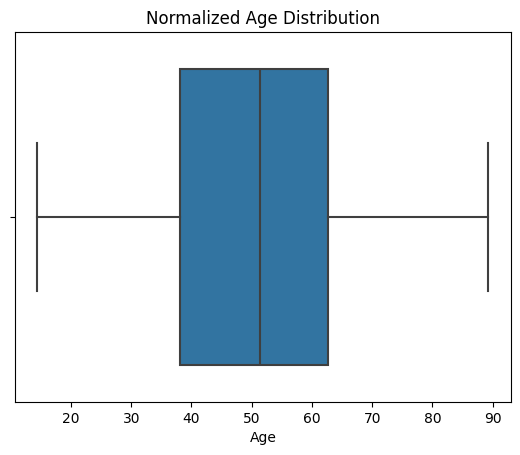

In [10]:
# Distribution of age to see if there are any outliers
sns.boxplot(data=df, x='Age')
plt.title('Normalized Age Distribution')

In [11]:
# Normalizing age
df['Age'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df

,Grade,Gender,Age,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
0,0,0,0.027044,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-0.777686,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.004455,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,-1.157620,1,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0,0,-1.238408,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,1,1,1.728157,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
858,1,0,2.194311,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
859,1,1,1.702396,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
860,1,0,0.796899,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [12]:
# Descriptive statistics
df.describe()

,Grade,Age,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
count,840.000000,8.400000e+02,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,...,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,0.419048,-2.030122e-16,0.482143,0.414286,0.258333,0.167857,0.133333,0.132143,0.116667,0.086905,...,0.032143,0.032143,0.032143,0.027381,0.027381,0.026190,0.001190,0.016667,0.070238,0.911905
std,0.493697,1.000000e+00,0.499979,0.492892,0.437979,0.373962,0.340137,0.338848,0.321214,0.281863,...,0.176484,0.176484,0.176484,0.163288,0.163288,0.159797,0.034503,0.128095,0.255700,0.283602
min,0.000000,-2.331593e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-8.197014e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.308957e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,7.512040e-01,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,2.457180e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data visualization 

### Clinical Features

Below, we visualize data and inspect: 
- How gender distributes by age for the current dataset;
- The prevalence of gliomas by gender.

Notably, there are more men in the dataset than women, but age is relatively similarly distributed across genders.

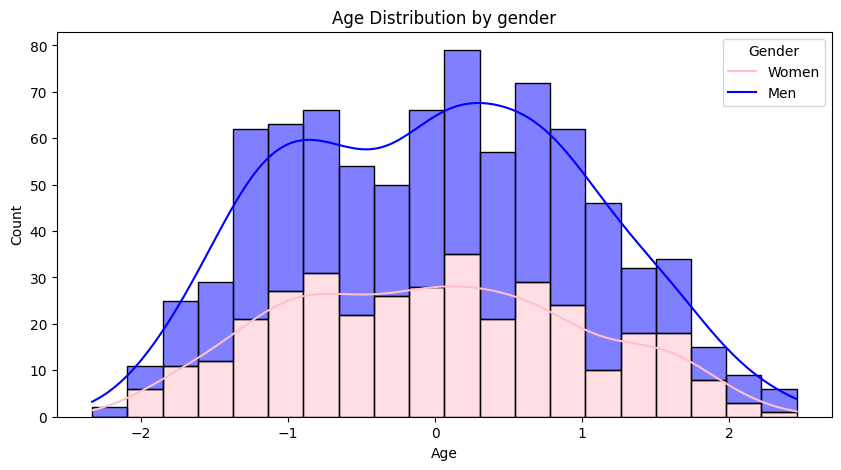

0    489
1    351
Name: Gender, dtype: int64

In [13]:
# Checking age distribution by gender
plt.figure(figsize=(10, 5))
sns.histplot(x='Age', data=df, hue='Gender', palette={0: 'blue', 1: 'pink'}, hue_order=[0, 1], multiple='stack', bins=20, kde=True)
plt.title('Age Distribution by gender')
plt.legend(title='Gender', labels=['Women', 'Men'])
plt.show()

# Counting the number of each gender in the dataset
df['Gender'].value_counts()

Notably, the cell below shows that our data is in full accordance with current glioma literature. Specifically: 
- Men are more affected than women; 
- This gender imbalance is more prominent for high-grades gliomas. As a reminder, high-grade GBMs is given a value of 1, whereas the LGGs are given a value of 0.

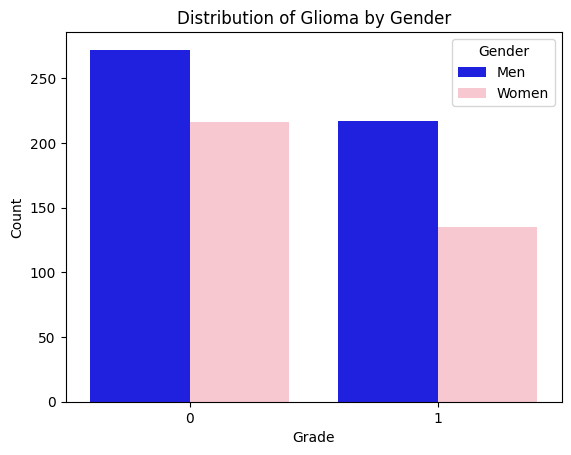

In [14]:
# Checking distribution of glioma by gender, color coding data based on gender
sns.countplot(data = df, x = 'Grade', hue='Gender', palette={0: 'blue', 1: 'pink'})
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Distribution of Glioma by Gender')
plt.legend(title='Gender', labels=['Men', 'Women'])

plt.show()

### Genetic Features

Now, we index the dataset to only visualize the 20 genetic features, specifically: 
- their mutation frequence; 
- the mutation distribution for each gene.

Both tables point to mutations on the IDH1 gene being extremely common. This is not surprising, as this gene is termed the “trunk” (or initiating) event in the genesis of IDH-mutant gliomas.

The other mutation patterns (such as the prevalent mutations on TPRX and ATRX genes) are coherent with the latest literature on glial cells tumorogenesis, despite the dataset not providing information as to whether a GBM is primary or secondary. To dive into glioma molecular bases and garner further insight on these tables, as well as the function of each gene in this dataset, please visit our [README](https://github.com/irenebernardi/Glioma-Grading-Classification/blob/main/README.md).

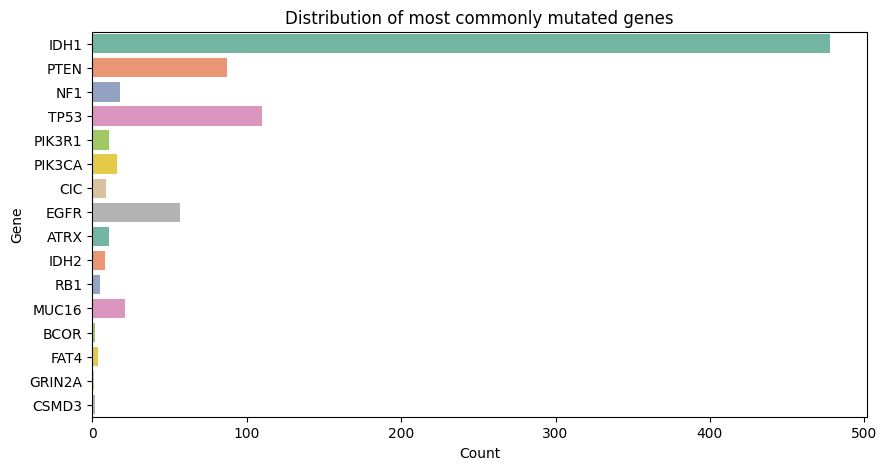

In [15]:
# Distribution of most commonly mutated genes in the dataset 
df['Most_commonly_mutated_gene'] = df.iloc[:, 3:-5].idxmax(axis=1)
plt.figure(figsize=(10, 5))

sns.countplot(data=df, y='Most_commonly_mutated_gene', palette='Set2')
plt.xlabel('Count')
plt.ylabel('Gene')
plt.title('Distribution of most commonly mutated genes')
plt.show()

In [16]:
#mutation distribution for each gene
fig = make_subplots(rows=5, cols=4)

# Loop through columns 3 to 22 (indexing from 0 to 19)
column_names = []  # List to store column names for legend

for i, column in enumerate(df.iloc[:, 3:23].columns, start=1):
    row_num = (i - 1) // 4 + 1  # Calculate row number
    col_num = (i - 1) % 4 + 1   # Calculate column number

    value_counts = df[column].value_counts()

    # Map the index to the desired labels
    x_labels = value_counts.index.map({0: 'Non-mutated', 1: 'Mutated'})

    fig.add_trace(
        go.Bar(x=x_labels, y=value_counts.values),
        row=row_num, col=col_num
    )
    
    column_names.append(f'Column {column}')  # Store column names for legend

    fig.update_xaxes(title_text=f'{column}', row=row_num, col=col_num)  

# Update layout for all subplots
fig.update_layout(title='Mutation Distribution for Each of the 20 Most Commonly Mutated Genes', width = 1000, height = 1200)
fig.for_each_trace(lambda trace: trace.update(name=column_names.pop(0)))  # Update trace names using stored column names
fig.show()

### Correlation Matrices

This section investigates correlation values for all genetic features, in an effort to understand how closely the dataset aligns with the latest glioma scientific literature. 

As a reminder:
-  a value of 1 was assigned to mutated genes, and a value of 1 was assigned to GBMs (which is an instance of High-Grade Gliomas). Thus, stronger correlation means that a gene's mutation is more likely linked to GBM.
- detailed insight on molecular underpinnings of gliomas is available in the project's [README](https://github.com/irenebernardi/Glioma-Grading-Classification/blob/main/README.md).

**Correlation between most commonly mutated genes (see heatmap below)**

- The heatmap shows a Pearson's value of 0.55 between the ATRX gene and the TP53 gene; indeed, these two genes often co-mutate in LGGs, but this is not the always the case for GBMs, which may influence the overall Pearson's value;

- The correlation value of 0.45 between the ATRX gene and the IDH1 gene are aligned with the scientific consensus of these two mutations playing a role in diffuse astrocytoma and anaplastic astrocytoma;

- FUBP1 and CI have a correlation value of 0.44: these genes often comutate in oligodendrogliomas, which represent a very small subset of this dataset. Further work could analyze comutations per LGG-subtype to shed more light on this matter;
 
- While literature usually points to IDH1 and IDH2 mutations being mutually exclusive, our dataset only shows a weak negative correlation of -0.16: this may be due to sampling variability or statistical noise. It should also be noted that this mutual exclusivity is a general trend that may not globally apply to all patients. 


As the molecular bases for gliomas are not fully understood, these interpretations of the correlation values may not be entirely accurate.

Text(0.5, 1.0, 'Correlation values among 20 most commonly mutated genes')

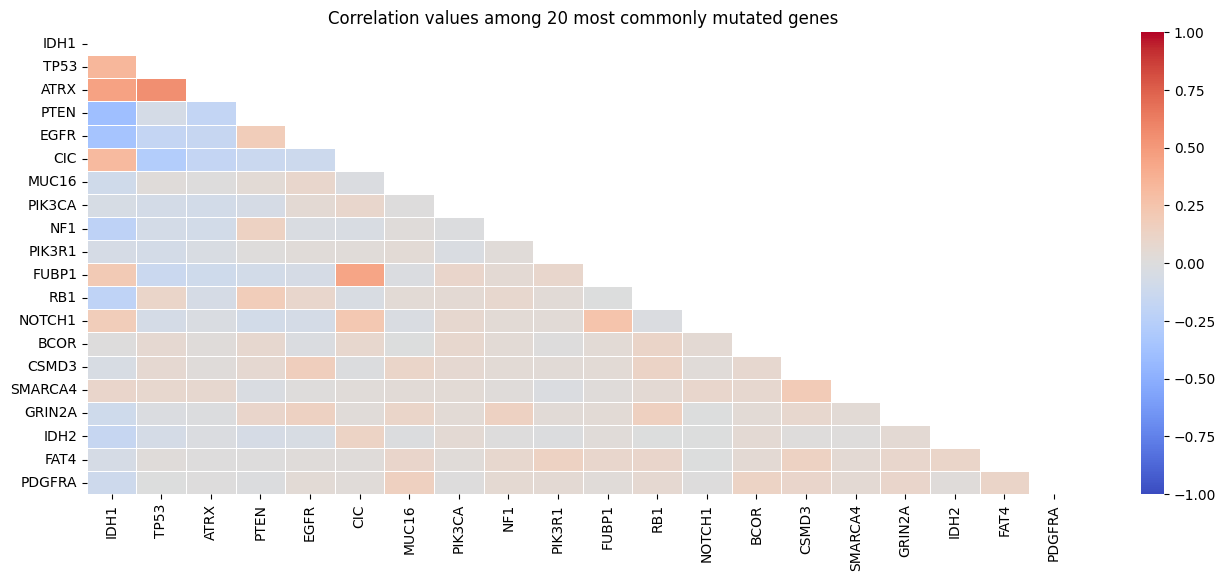

In [17]:
# Visualization of correlation between variables
plt.figure(figsize=(16, 6))
corr = df.iloc[:, 3 : 23].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# Using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix, vmin=-1, vmax=1, linewidths=.5, cmap='coolwarm')
plt.title("Correlation values among 20 most commonly mutated genes")

The cell below only plots genes ATRX, IDH1, TP53, CIC and FUBP1 for a better look at correlation values.

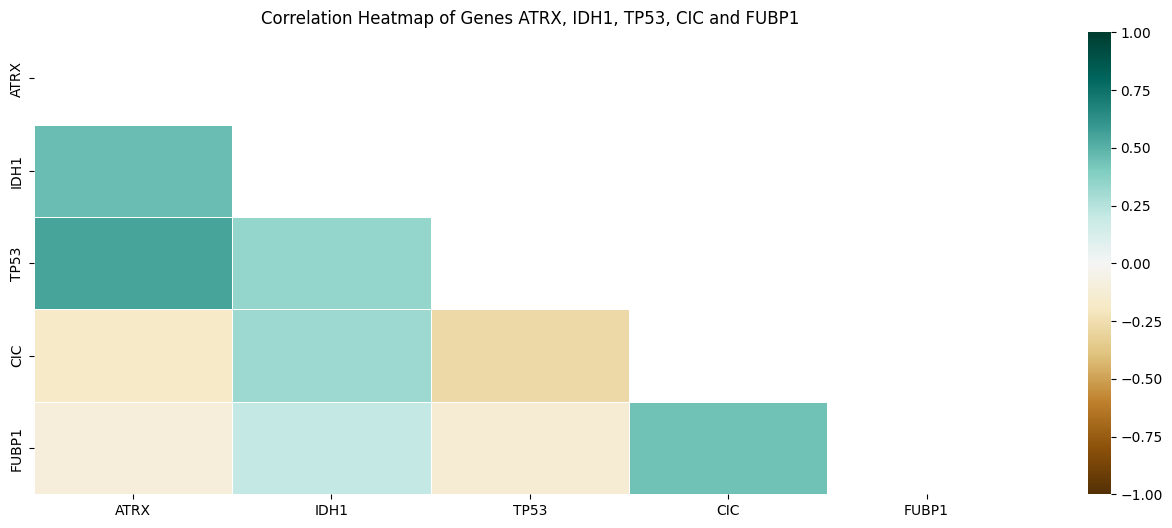

In [18]:
# Plotting only genes that showed correlation among them, for better visualization
correlated_genes = ['ATRX', 'IDH1', 'TP53', 'CIC', 'FUBP1']
plt.figure(figsize=(16, 6))
corr2 = df[correlated_genes].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix2 = np.triu(corr2)

# create heatmap
sns.heatmap(corr2, annot=True, mask=matrix2, vmin=-1, vmax=1, linewidths=.5, cmap='BrBG')
plt.title('Correlation Heatmap of Genes ATRX, IDH1, TP53, CIC and FUBP1')
plt.show()

**Correlation between most commonly mutated genes and Glioma Grade**

Below, we visualize correlation values for the same genes as well as Glioma Grade.  

Most notably, IDH1 has a strong negative correlation with GBM (-0.71). This gene usually mutates in LGG, and is only mutated in the rare cases in which the GBM is secondary (meaning it arises from what was previously diagnosed as a LGG).
 Thus, this correlation value makes sense: as most HGGs are primary, we would expect to find few IDH1 mutations in patients with GBM. 

However, as this dataset does not distinguish between primary and secondary GBMs, obtaining further support for this hypothesis is not possible. 

Text(0.5, 1.0, 'Correlation Heatmap of Genes ATRX, IDH1, TP53, CIC, FUBP1 and Grade')

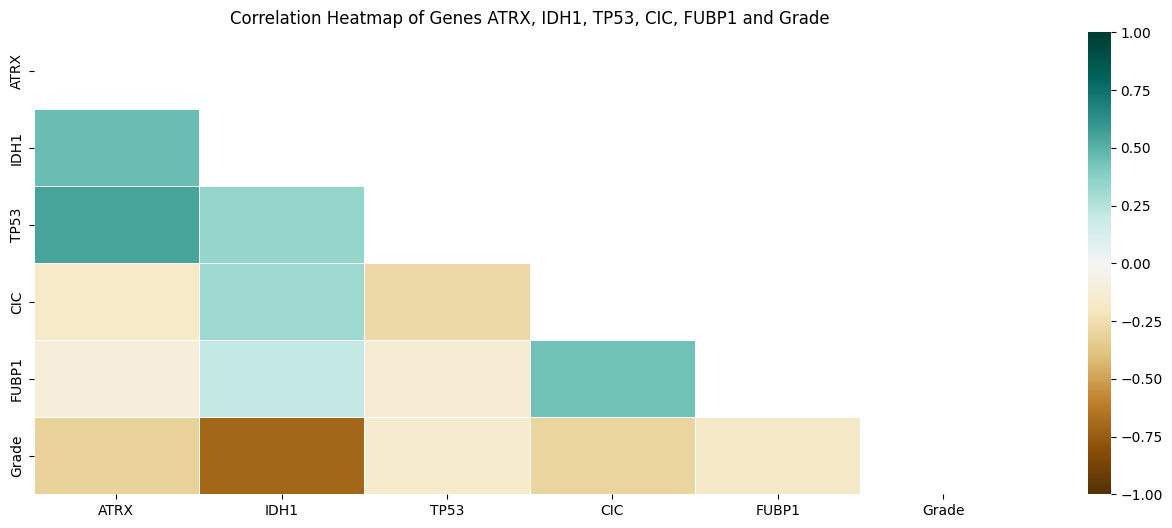

In [19]:
# Plotting selected genes correlation with glioma grade 
plt.figure(figsize=(16, 6))
corr_genesglioma = correlated_genes = ['ATRX', 'IDH1', 'TP53', 'CIC', 'FUBP1' , 'Grade']
corr3 = df[corr_genesglioma].corr()

# heatmap plot 
matrix3 = np.triu(corr3)
sns.heatmap(corr3, annot=True, mask=matrix3, vmin=-1, vmax=1, linewidths=.5, cmap='BrBG')
plt.title('Correlation Heatmap of Genes ATRX, IDH1, TP53, CIC, FUBP1 and Grade')

### Conclusions of the Exploratory Data Analysis 

Thorough comparison of the dataset with the existing literature on gliomas was necessary in order to fully comprehend the task at hand.
It appears that genetic and clinical information in the dataset aligns with what is currently known about LGGs and HGGs. Some variation is present, but we conclude that this may be due to statistical noise, sampling variability or the nature of TCGA. In fact: 
- the dataset only classifies GBMs as HGGs, which is no longer in accordance with the WHO guidelines;
- the dataset does not distinguish between GBM subtypes. 

Although the EDA proved insightful, these factors should caution against drawing definitive conclusions from these findings.


### Dimensionality Reduction: Multiple Correspondence Analysis (MCA)

To ensure using features that are responsible for the majority of the variance, dimensionality reduction is performed. As the features at hand are categorical ('mutated' vs 'non mutated', respectively coded as 1 and 0), we use Multiple Correspondence Analysis (MCA).

In [20]:
# MCA analysis on genes
genes = df.iloc[:, 3:-5]
mca = prince.MCA(one_hot=False)
mca = prince.MCA(n_components=2).fit(genes)
x_mca = mca.transform(genes)
x_mca = x_mca.to_numpy()
x_mca

array([[-0.16343666,  0.66251348],
       [-0.20576981,  0.39444739],
       [-0.4630209 , -0.29171703],
       ...,
       [ 0.19199419, -0.26365654],
       [ 0.32454638, -0.13507206],
       [ 0.12023919, -0.01492305]])

Here, we visualize the MCA components:

In [23]:
# Create a Scatter plot
fig = go.Figure(data=go.Scatter(x=x_mca[:, 0], y=x_mca[:, 1], mode='markers',
                                marker=dict(size=10, color=df['Grade'], colorscale='Portland')))

# Update layout
fig.update_layout(title='Scatter plot of principal components',
                   xaxis_title='First principal component',
                   yaxis_title='Second Principal Component',
                   width=1000,
                   height=1000)

fig.show()

Now, we compute eigenvalues and visualize the explained variance after the MCA. 

In [48]:
# Perform MCA
mca_ben = mca.MCA(genes)

# The eigenvalues (variances) can be accessed with
eigenvalues = mca_ben.L
# To get the explained variance
explained_variance = mca_ben.expl_var()

#visualize eigenvalues
eigenvalues

array([0.47491515, 0.33094593, 0.22816196, 0.22466313, 0.21885931,
       0.17316747, 0.14797472, 0.13440835, 0.11572705, 0.11196563,
       0.10217174, 0.07925566, 0.07115468, 0.06492957, 0.05057853,
       0.04106319, 0.01971341, 0.00695557, 0.00236227])

In [51]:
#visualize row coordinates
# Perform MCA
mca = prince.MCA()
mca = mca.fit(genes)

# Get row coordinates
row_coordinates = mca.row_coordinates(genes)
print("Row coordinates:")
print(row_coordinates)

Row coordinates:
            0         1
0   -0.163436  0.662512
1   -0.205771  0.394446
2   -0.463020 -0.291717
3   -0.178598 -0.119689
4   -0.463020 -0.291717
..        ...       ...
857  0.330845 -0.091743
858  0.191994 -0.263653
859  0.191994 -0.263653
860  0.324548 -0.135075
861  0.120239 -0.014925

[840 rows x 2 columns]


In [52]:
# visualize column contributions
column_contributions = mca.column_contributions_
print("Column contributions:")
print(column_contributions)

Column contributions:
                  0         1
IDH1_0     0.146819  0.005286
IDH1_1     0.157694  0.005677
TP53_0     0.038762  0.059418
TP53_1     0.054802  0.084005
ATRX_0     0.038600  0.022792
ATRX_1     0.110820  0.065435
PTEN_0     0.020799  0.002767
PTEN_1     0.103111  0.013718
EGFR_0     0.015563  0.000509
EGFR_1     0.101158  0.003308
CIC_0      0.001895  0.039831
CIC_1      0.012444  0.261591
MUC16_0    0.001640  0.000185
MUC16_1    0.012416  0.001397
PIK3CA_0   0.000282  0.002930
PIK3CA_1   0.002958  0.030785
NF1_0      0.003082  0.000174
NF1_1      0.035552  0.002011
PIK3R1_0   0.000392  0.000667
PIK3R1_1   0.005700  0.009702
FUBP1_0    0.000365  0.012769
FUBP1_1    0.006440  0.225589
RB1_0      0.002004  0.000190
RB1_1      0.040078  0.003796
NOTCH1_0   0.000605  0.005136
NOTCH1_1   0.012777  0.108405
BCOR_0     0.000028  0.000180
BCOR_1     0.000795  0.005025
CSMD3_0    0.000383  0.000003
CSMD3_1    0.011545  0.000080
SMARCA4_0  0.000068  0.000032
SMARCA4_1  0.00205

In [53]:
# Explained variance by each column
mca.column_contributions_.style.format('{:.0%}')

,0,1
IDH1_0,15%,1%
IDH1_1,16%,1%
TP53_0,4%,6%
TP53_1,5%,8%
ATRX_0,4%,2%
ATRX_1,11%,7%
PTEN_0,2%,0%
PTEN_1,10%,1%
EGFR_0,2%,0%
EGFR_1,10%,0%


Below, we visualize the explained variance by component:


In [40]:
#visualize explained variance by component 
fig = go.Figure(data=go.Scatter(x=list(range(1, len(explained_variance)+1)), y=explained_variance))

# Update layout
fig.update_layout(title='Explained Variance by Component',
                   xaxis_title='Component',
                   yaxis_title='Explained Variance',
                   xaxis = dict(
                       dtick = 1  # sets the tick step to 1
                   ))

fig.show()

### Conclusions on the dimensionality reduction 

MCA was employed to tackle the categorical nature of the features. However, the explained variance by each component is very low, indicating that dimensionality reduction may not be warranted for the 20 genes in the dataset.
Future work should focus on finding different dimensionality reduction approaches that are appropriate for categorical features, and determining whether the outcome is similar. 

## Model Selection

A variety of binary classification models will be trained, namely: Logistic Regression, DecisionTrees, Random Forest and AdaBoost.

In [21]:
# Remove column 'most commonly mutated genes' from dataframe before fitting model, otherwise string error
df = df.iloc[:, :-16]

In [22]:
# Define label and features
X = df.drop(columns=['Grade'])
y = df['Grade']
y.value_counts()

0    488
1    352
Name: Grade, dtype: int64

In [23]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [24]:
# Creating a list of potential models: 
models = []
model1 = LogisticRegression()
models.append(model1)
model2 = tree.DecisionTreeClassifier()
models.append(model2)
model3 = RandomForestClassifier()
models.append(model3)
model4 = AdaBoostClassifier()
models.append(model4)

Code iterates through a list of machine learning models, fits each model to training data, evaluates its performance using accuracy, recall, confusion matrix, and ROC AUC score on test data, and then visualizes the confusion matrix and ROC curve for each model. The results, including accuracy, recall, and ROC AUC, are stored in a dictionary for further analysis.

LogisticRegression()
Accuracy of LogisticRegression() is 0.8809523809523809
Recall (sensitivity) of LogisticRegression() is 0.9369369369369369


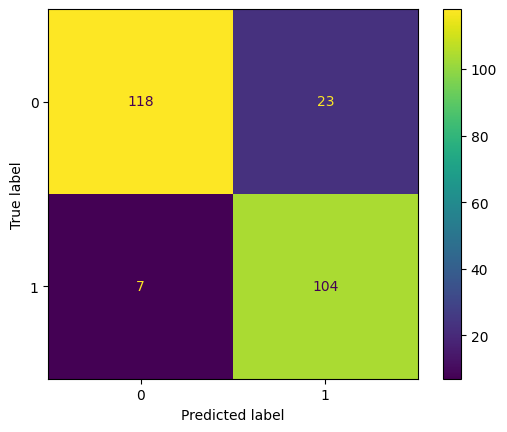

ROC AUC score of LogisticRegression() is 0.8869081847805251


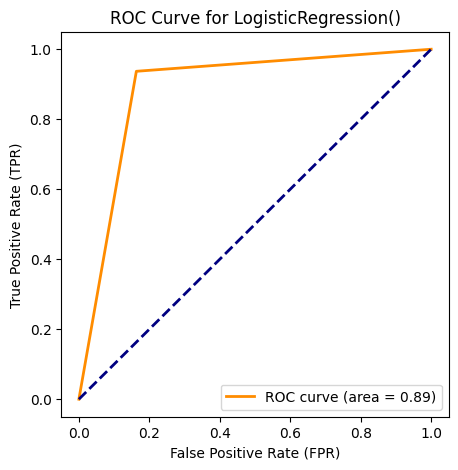

-------------------------------------------------------
DecisionTreeClassifier()
Accuracy of DecisionTreeClassifier() is 0.7976190476190477
Recall (sensitivity) of DecisionTreeClassifier() is 0.7837837837837838


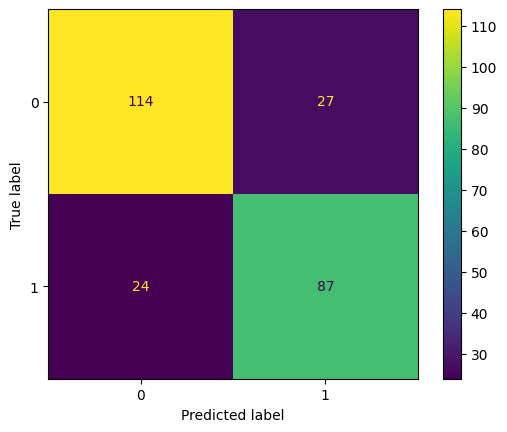

ROC AUC score of DecisionTreeClassifier() is 0.7961472110408281


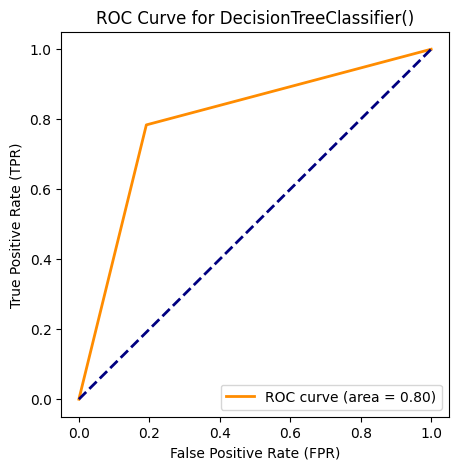

-------------------------------------------------------
RandomForestClassifier()
Accuracy of RandomForestClassifier() is 0.8055555555555556
Recall (sensitivity) of RandomForestClassifier() is 0.7657657657657657


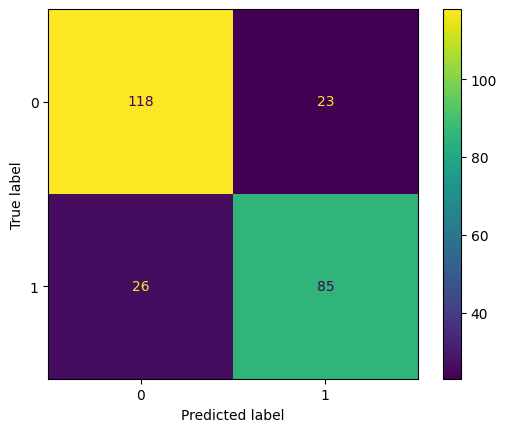

ROC AUC score of RandomForestClassifier() is 0.8013225991949395


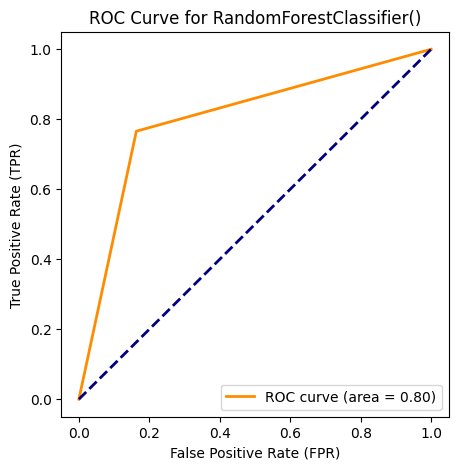

-------------------------------------------------------
AdaBoostClassifier()
Accuracy of AdaBoostClassifier() is 0.8690476190476191
Recall (sensitivity) of AdaBoostClassifier() is 0.9279279279279279


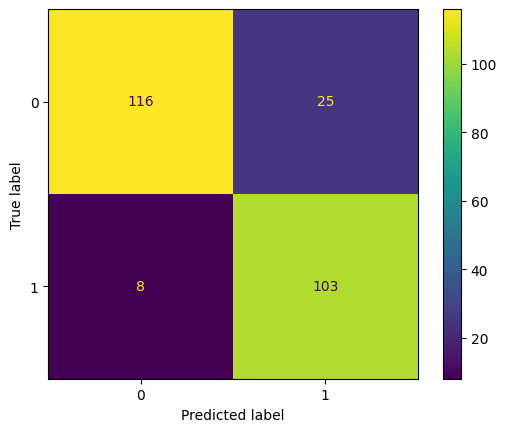

ROC AUC score of AdaBoostClassifier() is 0.8753114816944604


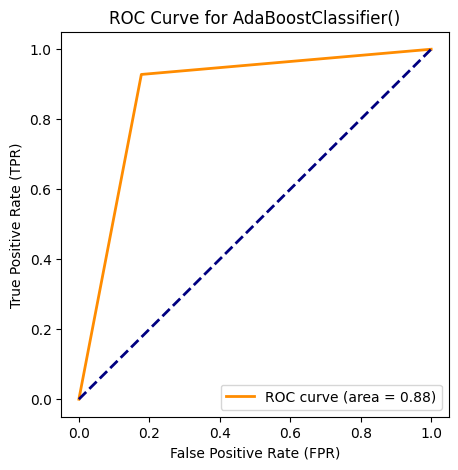

-------------------------------------------------------


In [25]:
dict = {} # Creating dict for storing model's accuracy 

# Model evaluation with accuracy, cm, f1, roc scores
for model in models:
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    dict[model] = round(recall, 2) # Add key-value pair to the dictionary
    print(f"Accuracy of {model} is {accuracy}")
    print(f'Recall (sensitivity) of {model} is {recall}')

    cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
    disp.plot()
    plt.show()

    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC AUC score of {model} is {roc_auc}")

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {model}')
    plt.legend(loc='lower right')
    plt.show()
    print("-------------------------------------------------------")

In [26]:
# Getting first two models with the best recall
sorted_dict = OrderedDict(sorted(dict.items(), key = itemgetter(1), reverse = True))
first2pairs = {k: sorted_dict[k] for k in list(sorted_dict)[:2]}
print(f'The two models with best recall are {first2pairs}')

The two models with best recall are {LogisticRegression(): 0.94, AdaBoostClassifier(): 0.93}


Two models with the best results.

In [27]:
# Removing models from models list that didnt performe well
keys = first2pairs.keys()
models = [model for model in models if model in keys]
models

[LogisticRegression(), AdaBoostClassifier()]

## Cross validation for both models, accuracy and recall

Cross-validation for model evaluation on varying numbers of splits (5 and 10 folds). It calculates and stores the mean accuracy and recall scores for each model and split configuration in separate dictionaries, providing insights for model performance comparison.

In [28]:
# Cross validation (ACCURACY, keeping for paper comparison)
splits = [5, 10] # Trying 5 and 10 folds
dict_cv_accuracy = {} # Creating dict for storing model's accuracy
dict_cv_recall = {} # Creating dict for storing model's recall
for i in splits:
    kf = StratifiedKFold(n_splits = i, shuffle = True, random_state = 42)
    for model in models:
        name = '{}_{}'.format(model, i)
        accuracy = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy').mean()
        dict_cv_accuracy[name] = accuracy
        recall = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall').mean()
        dict_cv_recall[name] = recall
        print(f'''
                Accuracy of {model} for {i} splits is {round(accuracy.mean(), 5)} 
                Recall of {model} for {i} splits is {round(recall.mean(), 5)} 
            ''')
    print("                ---------------------------------------------------------------")


                Accuracy of LogisticRegression() for 5 splits is 0.84007 
                Recall of LogisticRegression() for 5 splits is 0.86701 
            

                Accuracy of AdaBoostClassifier() for 5 splits is 0.83843 
                Recall of AdaBoostClassifier() for 5 splits is 0.85043 
            
                ---------------------------------------------------------------

                Accuracy of LogisticRegression() for 10 splits is 0.83647 
                Recall of LogisticRegression() for 10 splits is 0.8585 
            

                Accuracy of AdaBoostClassifier() for 10 splits is 0.83144 
                Recall of AdaBoostClassifier() for 10 splits is 0.85017 
            
                ---------------------------------------------------------------


In [29]:
# Getting first two models with the best accuracy
sorted_dict_cv = OrderedDict(sorted(dict_cv_accuracy.items(), key = itemgetter(1), reverse = True))
sorted_dict_cv

OrderedDict([('LogisticRegression()_5', 0.8400695349847893),
             ('AdaBoostClassifier()_5', 0.8384325655512097),
             ('LogisticRegression()_10', 0.8364699006428988),
             ('AdaBoostClassifier()_10', 0.8314436002337814)])

In [30]:
# Getting first two models with the best recall
sorted_dict_cv = OrderedDict(sorted(dict_cv_recall.items(), key = itemgetter(1), reverse = True))
sorted_dict_cv

OrderedDict([('LogisticRegression()_5', 0.8670068027210884),
             ('LogisticRegression()_10', 0.8584999999999999),
             ('AdaBoostClassifier()_5', 0.8504251700680273),
             ('AdaBoostClassifier()_10', 0.8501666666666667)])

# Logistic regression

## GridSearch for Logistic Regression, accuracy

Performing GridSearch for Logistic regression with accuracy as a scoring for comparison with the paper.

In [31]:
kf_10 = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)
kf_5 = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)

In [32]:
# GridSearchCV for logistic regression

param_grid = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20), #more granular params bc evenly dsitributed in logspace
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }

grid_search = GridSearchCV(estimator = models[0],
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = kf_10).fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation score: 0.8501753360607831


In [33]:
# y_pred with the best parameters from GridSearchCV
y_pred_accuracy = best_model.predict(X_test)

accuracy_gs = accuracy_score(y_test, y_pred_accuracy)
y_pred = models[0].predict(X_test)
prev_accuracy = accuracy_score(y_test, y_pred)
print(f"Previous accuracy of LogisticRegression is {prev_accuracy}")

if accuracy_gs > prev_accuracy:
    print("Accuracy improved after GridSearch")
    print(f'GridSearch accuracy is {accuracy_gs}')
else: 
    print("Accuracy did not improve after GridSearch")

Previous accuracy of LogisticRegression is 0.8809523809523809
Accuracy did not improve after GridSearch


## RandomSearch for Logistic Regression, accuracy

Performing RandomSearch for Logistic regression with accuracy as a scoring for comparison with the paper.

In [34]:
#Randomsearch for logistic regression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20),
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

randomized_search = RandomizedSearchCV(estimator = models[0],
                           param_distributions = param_grid,
                           scoring = 'accuracy',
                           cv = kf_10).fit(X_train, y_train)

# Get the best estimator
best_model_rs = randomized_search.best_estimator_

print(f"Best parameters: {randomized_search.best_params_}")
print(f"Best cross-validation score: {randomized_search.best_score_}")

Best parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.08858667904100823}
Best cross-validation score: 0.8433664523670368


In [35]:
y_pred_accuracy_rs = best_model_rs.predict(X_test)
accuracy_rs = accuracy_score(y_test, y_pred_accuracy_rs)

y_pred = models[0].predict(X_test)
prev_accuracy = accuracy_score(y_test, y_pred)
print(f"Previous accuracy of LogisticRegression is {prev_accuracy}")

if accuracy_rs > prev_accuracy:
    print("Accuracy improved after Random Search")
    print(f'RandomSearch accuracy is {accuracy_rs}')
else: 
    print("Accuracy did not improve after RandomSearch")

Previous accuracy of LogisticRegression is 0.8809523809523809
Accuracy did not improve after RandomSearch


________________________________________________________________________________________________________________________

## GridSearch for logistic regression, recall

Performing GridSearch for Logistic regression with accuracy as a recall. Recall, also known as Sensitivity, measures the model's ability to correctly identify positive instances.

In [36]:
# GridSearchCV for logistic regression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20), #more granular params bc evenly dsitributed in logspace
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

grid_search = GridSearchCV(estimator = models[0],
                           param_grid = param_grid,
                           scoring = 'recall',
                           cv = kf_10).fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation score: 0.8835


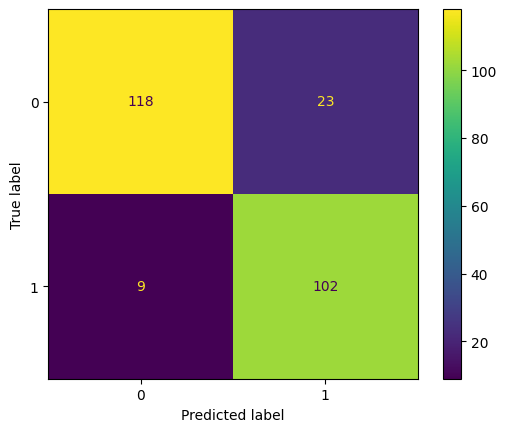

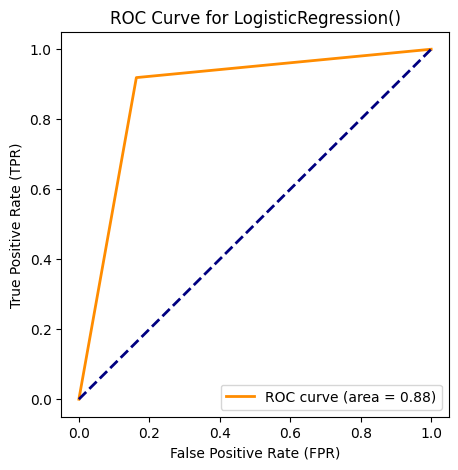

Recall of new LogisticRegression is 0.918918918918919


In [37]:
# y_pred with the best recall parameters from GridSearchCV
y_pred_recall = best_model.predict(X_test)

recall_gs = recall_score(y_test, y_pred_recall)
cm = confusion_matrix(y_test, y_pred_recall, labels = models[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = models[0].classes_)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_recall)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for {models[0]}')
plt.legend(loc='lower right')
plt.show()
print(f"Recall of new LogisticRegression is {recall_gs}")

In [38]:
y_pred = models[0].predict(X_test)
prev_accuracy = recall_score(y_test, y_pred)
print(f"Previous recall of LogisticRegression is {prev_accuracy}")

if recall_gs > prev_accuracy:
    print("Recall improved after GridSearch")
    print(f'GridSearch recall is {recall_gs}')
else: 
    print("Recall did not improve after GridSearch")

Previous recall of LogisticRegression is 0.9369369369369369
Recall did not improve after GridSearch


## RandomSearch for Logistic Regression, recall

Performing RandomSearch for Logistic regression with accuracy as a recall. Recall, also known as Sensitivity, measures the model's ability to correctly identify positive instances.

In [39]:
#Randomsearch for logistic regression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20),
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

randomized_search = RandomizedSearchCV(estimator = models[0],
                           param_distributions = param_grid,
                           scoring = 'recall',
                           cv = kf_10).fit(X_train, y_train)

# Get the best estimator
best_model_rs = randomized_search.best_estimator_

print(f"Best parameters: {randomized_search.best_params_}")
print(f"Best cross-validation score: {randomized_search.best_score_}")

Best parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1438.44988828766}
Best cross-validation score: 0.8584999999999999


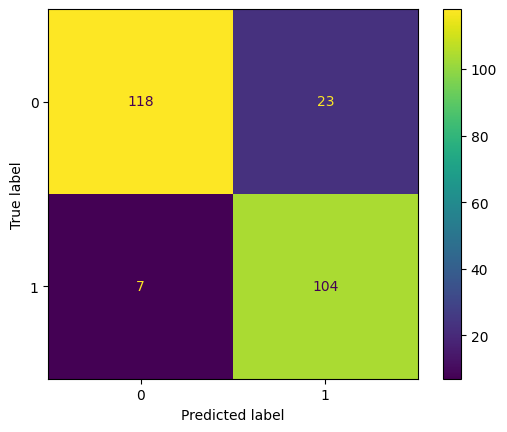

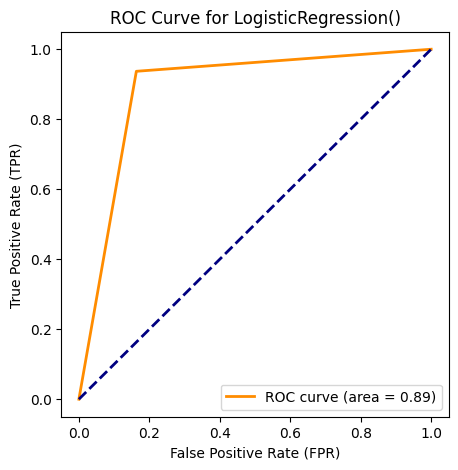

Accuracy of new LogisticRegression is 0.8809523809523809


In [40]:
#now use best parameters from random search to predict y_pred

y_pred_recall_rs = best_model_rs.predict(X_test)

recall_rs = accuracy_score(y_test, y_pred_recall_rs)
cm_rs = confusion_matrix(y_test, y_pred_recall_rs, labels = models[0].classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rs, display_labels = models[0].classes_)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_recall_rs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for {models[0]}')
plt.legend(loc='lower right')
plt.show()
print(f"Accuracy of new LogisticRegression is {recall_rs}")

In [41]:
y_pred = models[0].predict(X_test)
prev_accuracy = accuracy_score(y_test, y_pred)
print(f"Previous recall of LogisticRegression is {prev_accuracy}")

if recall_rs > prev_accuracy:
    print("Recall improved after Random Search")
    print(f'RandomSearch recall is {recall_rs}')
else: 
    print("Recall did not improve after RandomSearch")

Previous recall of LogisticRegression is 0.8809523809523809
Recall did not improve after RandomSearch


# AdaBoost

## GridSearch for AdaBoost, recall

Performing GridSearch for AdaBoost with accuracy as a recall. Recall, also known as Sensitivity, measures the model's ability to correctly identify positive instances.

In [42]:
# GridSearchCV for SVM

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

grid_search = GridSearchCV(estimator = models[1],
                           param_grid = param_grid,
                           scoring = 'recall',
                           cv = kf_10).fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}
Best cross-validation score: 0.9166666666666666


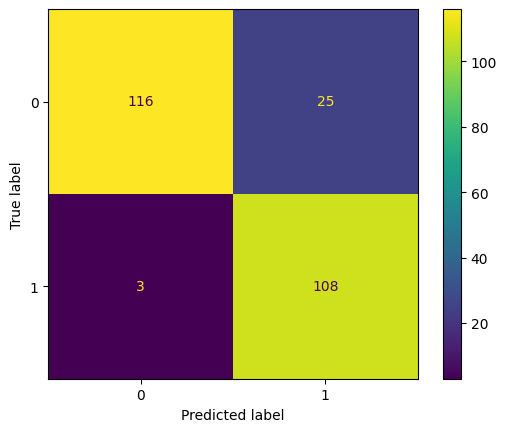

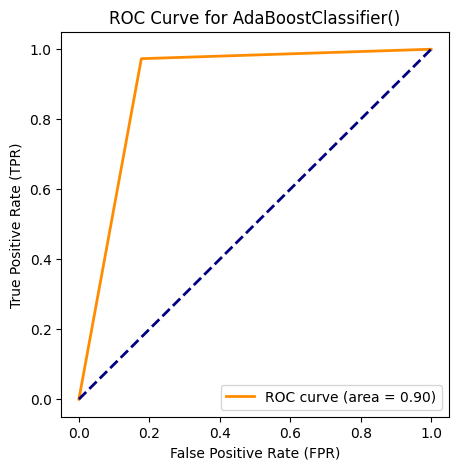

Recall of new AdaBoostClassifier() is 0.972972972972973


In [43]:
# y_pred with the best recall parameters from GridSearchCV
y_pred_recall = best_model.predict(X_test)

recall_gs = recall_score(y_test, y_pred_recall)
cm = confusion_matrix(y_test, y_pred_recall, labels = models[1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = models[1].classes_)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_recall)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for {models[1]}')
plt.legend(loc='lower right')
plt.show()
print(f"Recall of new {models[1]} is {recall_gs}")

In [44]:
y_pred = models[1].predict(X_test)
prev_accuracy = recall_score(y_test, y_pred)
print(f"Previous recall of {models[1]} is {prev_accuracy}")

if recall_gs > prev_accuracy:
    print("Recall improved after GridSearch")
    print(f'GridSearch recall is {recall_gs}')
else: 
    print("Recall did not improve after GridSearch")

Previous recall of AdaBoostClassifier() is 0.9279279279279279
Recall improved after GridSearch
GridSearch recall is 0.972972972972973


## RandomSearch for AdaBoost, recall

Performing RandomSearch for AdaBoost with accuracy as a recall. Recall, also known as Sensitivity, measures the model's ability to correctly identify positive instances.

In [45]:
# RandomSearch for SVM

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

grid_search = RandomizedSearchCV(estimator = models[1],
                           param_distributions = param_grid,
                           scoring = 'recall',
                           cv = kf_10).fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'n_estimators': 50, 'learning_rate': 0.1, 'algorithm': 'SAMME'}
Best cross-validation score: 0.9166666666666666


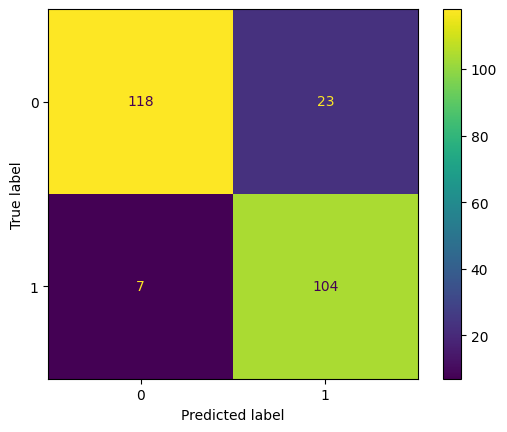

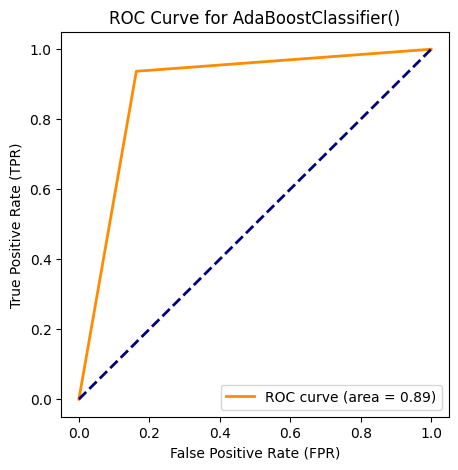

Recall of new AdaBoostClassifier() is 0.9369369369369369


In [46]:
#now use best parameters from random search to predict y_pred

y_pred_recall_rs = best_model_rs.predict(X_test)

recall_rs = recall_score(y_test, y_pred_recall_rs)
cm_rs = confusion_matrix(y_test, y_pred_recall_rs, labels = models[1].classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rs, display_labels = models[1].classes_)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_recall_rs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for {models[1]}')
plt.legend(loc='lower right')
plt.show()
print(f"Recall of new {models[1]} is {recall_rs}")

In [47]:
y_pred = models[0].predict(X_test)
prev_recall = recall_score(y_test, y_pred)
print(f"Previous recall of {models[1]} is {prev_accuracy}")

if recall_rs > prev_recall:
    print("Recall improved after Random Search")
    print(f'RandomSearch accuracy is {recall_rs}')
else: 
    print("Recall did not improve after RandomSearch")

Previous recall of AdaBoostClassifier() is 0.9279279279279279
Recall did not improve after RandomSearch
